In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
import sys
sys.path.append('../src')
from main import load_data, Extractor, remove_stop_words, negation_handling, clean_text, lemmatizing
from preprocessing import emoji_tagging
from scipy.sparse import save_npz, load_npz
import numpy as np
import nltk
from nltk import word_tokenize
from util import curry
from pprint import pprint

from wordcloud import WordCloud
import matplotlib.pyplot as plt

time: 4.69 s


# Load data and do some preprocessing:

In [3]:
Xtr_text, Ytr, Xte_text, Yte = load_data('../aclImdb/train/', '../aclImdb/test/')

Load Data...
Done loading data!

time: 40.8 s


In [4]:
extractor1 = Extractor(Xtr_text, Xte_text)\
        .bind(curry(emoji_tagging))\
        .bind(curry(remove_stop_words))\
        .bind(curry(lemmatizing))\
        .bind(curry(negation_handling))\
        .bind(curry(clean_text))

time: 19min 17s


In [5]:
extractor2 = Extractor(Xtr_text, Xte_text)\
        .bind(curry(remove_stop_words))\
        .bind(curry(lemmatizing))\
        .bind(curry(clean_text))

time: 3min 9s


In [6]:
extractor3 = Extractor(Xtr_text, Xte_text)\
        .bind(curry(lemmatizing))\
        .bind(curry(clean_text))

time: 1min 14s


In [7]:
extractor4 = Extractor(Xtr_text, Xte_text)\
        .bind(curry(clean_text))

time: 34.3 s


In [8]:
Xtr1, Xte1 = extractor1.get_features()
Xtr2, Xte2 = extractor2.get_features()
Xtr3, Xte3 = extractor3.get_features()
Xtr4, Xte4 = extractor4.get_features()

time: 1.15 ms


# Split the Training Dataset up in positive and negative sets

Lets analyze the datasets

In [9]:
Xtr_np = np.array(Xtr1)
Xte_np = np.array(Xte1)

Xtr_pos = Xtr_np[Ytr>0]
Xtr_neg = Xtr_np[Ytr<1]

time: 1.73 s


In [10]:
super_review_pos = " ".join(Xtr_pos)
super_review_neg = " ".join(Xtr_neg)

time: 502 ms


In [11]:
tokens_pos = word_tokenize(super_review_pos)
tokens_neg = word_tokenize(super_review_neg)

time: 12.5 s


In [12]:
frequency_dist_pos = nltk.FreqDist(tokens_pos)
frequency_dist_neg = nltk.FreqDist(tokens_neg)

time: 2.04 s


In [29]:
pos = sorted(frequency_dist_pos.items(), key=lambda x:-x[1])[:50]
neg = sorted(frequency_dist_neg.items(), key=lambda x:-x[1])[:50]
print(pos)
print(neg)

[('film', 22447), ('movie', 20297), ('not', 13692), ('t', 13338), ('one', 11939), ('like', 7540), ('time', 7526), ('story', 6715), ('good', 6690), ('character', 6530), ('great', 5520), ('well', 5457), ('see', 5456), ('would', 5316), ('make', 5085), ('get', 4715), ('also', 4706), ('scene', 4669), ('life', 4504), ('really', 4443), ('show', 4286), ('first', 4075), ('way', 4041), ('love', 3960), ('people', 3902), ('even', 3689), ('best', 3614), ('year', 3599), ('much', 3458), ('made', 3443), ('could', 3365), ('two', 3352), ('many', 3221), ('think', 3112), ('never', 3083), ('thing', 3069), ('little', 2990), ('performance', 2978), ('go', 2953), ('still', 2922), ('actor', 2881), ('work', 2860), ('watch', 2838), ('end', 2837), ('man', 2745), ('seen', 2584), ('find', 2563), ('take', 2546), ('say', 2536), ('come', 2485)]
[('movie', 25138), ('t', 19840), ('film', 19615), ('not', 15347), ('one', 11186), ('like', 9777), ('would', 7076), ('time', 6414), ('character', 6250), ('good', 5887), ('bad', 5

## Create a wordcloud based on the top 50 words in each set

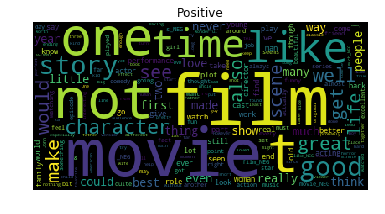

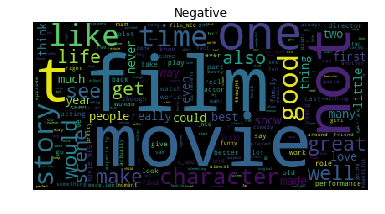

time: 1.05 s


In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(50,50))

wordcloud_pos = WordCloud().generate_from_frequencies(frequency_dist_pos)
wordcloud_neg = WordCloud().generate_from_frequencies(frequency_dist_pos)

plt.imshow(wordcloud_pos)
plt.title("Positive")
plt.axis("off")
plt.savefig("positive_wordcloud.png", bbox_inches='tight')
plt.show()

plt.imshow(wordcloud_neg)
plt.title("Negative")
plt.axis("off")
plt.savefig("negative_wordcloud.png", bbox_inches='tight')
plt.show()

# Feature selection: Kbest based on Chi test and ngram range performance

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

time: 1.34 ms


In [30]:
def vectorize(Xtr, Ytr, Xte, Yte, ngram_r=(1,1)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_r)

    vectorizer.fit(Xtr, Ytr)
    XtrS = vectorizer.transform(Xtr)
    XteS = vectorizer.transform(Xte)
    print("Number of Features: ", len(vectorizer.get_feature_names()))
    
    return XtrS, XteS

def k_Best(Xtr, Ytr, Xte, Yte, k_best):
    Select = SelectKBest(chi2, k=k_best).fit(Xtr, Ytr)
    XtrS = Select.transform(Xtr)
    XteS = Select.transform(Xte)

    print("Number of features after select KBest", k_best)
    
    return XtrS, XteS

def plot_scores(k_list, f1_scores, p_scores, r_scores, labels, save_to_file=False):
    for f1, k in zip(f1_scores, k_list):
        plt.semilogx(k, f1)
        plt.title("F-1 score for best k features")
    plt.legend(labels)
    plt.xlabel("k")
    if save_to_file:
        plt.savefig('f1-score.png', bbox_inches='tight')
    plt.show()
    
    
    for p, k in zip(p_scores, k_list):
        plt.semilogx(k, p)
    plt.title("Precision for best k features")
    plt.legend(labels)
    plt.xlabel("k")
    if save_to_file:
        plt.savefig('precision-score.png', bbox_inches='tight')
    plt.show()
        
    
    for r, k in zip(r_scores, k_list):
        plt.semilogx(k, r)
    plt.title("Recall for best k features")
    plt.legend(labels)
    plt.xlabel("k")
    if save_to_file:
        plt.savefig('recall-score.png', bbox_inches='tight')
    plt.show()


time: 11 ms


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time 

time: 999 µs


In [32]:
Xtr_11_1, Xte_11_1 = vectorize(Xtr1, Ytr, Xte1, Yte, ngram_r=(1,1))
Xtr_11_2, Xte_11_2 = vectorize(Xtr2, Ytr, Xte2, Yte, ngram_r=(1,1))
Xtr_11_3, Xte_11_3 = vectorize(Xtr3, Ytr, Xte4, Yte, ngram_r=(1,1))
Xtr_11_4, Xte_11_4 = vectorize(Xtr4, Ytr, Xte4, Yte, ngram_r=(1,1))

Xtr_set = [Xtr_11_1, Xtr_11_2, Xtr_11_3, Xtr_11_4]
Xte_set = [Xte_11_1, Xte_11_2, Xte_11_3, Xte_11_4]

k_list = [
    [10, 100, 1000, 10000, 50000, 88391],
    [10, 100, 1000, 10000, 50000, 69950],
    [10, 100, 1000, 10000, 50000, 72198],
    [10, 100, 1000, 10000, 50000, 73986]
]

labels=["All preprocessing", "wo negation/emoji", "wo negation/emoji/stopword_removing", "Only clean text"]

Number of Features:  88391
Number of Features:  69950
Number of Features:  72198
Number of Features:  73986
time: 48.3 s


In [33]:
# Xtr_11, Xte_11 = vectorize(Xtr1, Ytr, Xte1, Yte, ngram_r=(1,1))
# Xtr_22, Xte_22 = vectorize(Xtr1, Ytr, Xte1, Yte, ngram_r=(2,2))
# Xtr_33, Xte_33 = vectorize(Xtr1, Ytr, Xte1, Yte, ngram_r=(3,3))
# Xtr_12, Xte_12 = vectorize(Xtr1, Ytr, Xte1, Yte, ngram_r=(1,2))
# Xtr_13, Xte_13 = vectorize(Xtr1, Ytr, Xte1, Yte, ngram_r=(1,3))

# Xtr_set = [Xtr_11, Xtr_22, Xtr_33, Xtr_12, Xtr_13]
# Xte_set = [Xte_11, Xte_22, Xte_33, Xte_12, Xte_13]

# k_list = [
#     [10, 100, 1000, 10000, 50000, 88391],
#     [10, 100, 1000, 10000, 100000, 1000000, 1790783],
#     [10, 100, 1000, 10000, 100000, 1000000, 2842984],
#     [10, 100, 1000, 10000, 100000, 1000000, 1879174],
#     [10, 100, 1000, 10000, 100000, 1000000, 4722158]
# ]

# labels=["ngram=(1,1)", "ngram=(2,2)", "ngram=(3,3)", "ngram=(1,2)", "ngram=(1,3)"]

time: 1.19 ms


In [34]:

f1_scores_all = []
p_scores_all = []
r_scores_all  = []

for (Xtrain, Xtest), k_best in zip(zip(Xtr_set, Xte_set), k_list):
    f1_scores = []
    p_scores = []
    r_scores  = []
    
    for k in k_best:
        Xtr_vec, Xte_vec = k_Best(Xtrain, Ytr, Xtest, Yte, k)
        classifier = LogisticRegression(solver='lbfgs')
        classifier.fit(Xtr_vec, Ytr)
        Yte_hat = classifier.predict(Xte_vec)

        f1_scores.append(f1_score(Yte, Yte_hat))
        p_scores.append(precision_score(Yte, Yte_hat))
        r_scores.append(recall_score(Yte, Yte_hat))

    f1_scores_all.append(f1_scores)
    p_scores_all.append(p_scores)
    r_scores_all.append(r_scores)
    


Number of features after select KBest 10
Number of features after select KBest 100
Number of features after select KBest 1000
Number of features after select KBest 10000
Number of features after select KBest 50000
Number of features after select KBest 88391
Number of features after select KBest 10
Number of features after select KBest 100
Number of features after select KBest 1000
Number of features after select KBest 10000
Number of features after select KBest 50000
Number of features after select KBest 69950
Number of features after select KBest 10
Number of features after select KBest 100
Number of features after select KBest 1000
Number of features after select KBest 10000
Number of features after select KBest 50000
Number of features after select KBest 72198


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Number of features after select KBest 10
Number of features after select KBest 100
Number of features after select KBest 1000
Number of features after select KBest 10000


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Number of features after select KBest 50000
Number of features after select KBest 73986
time: 19.9 s


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


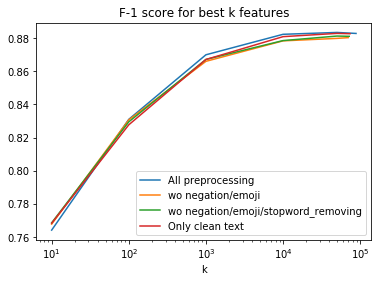

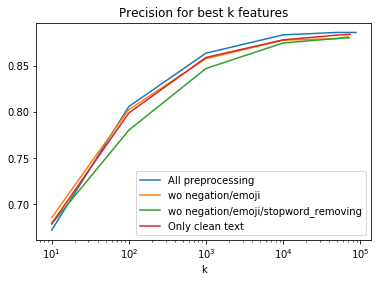

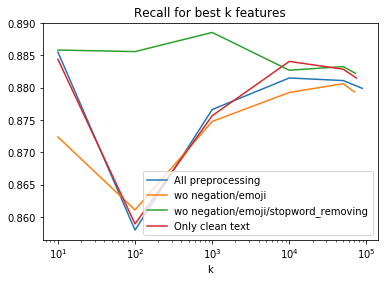

time: 2.49 s


In [35]:
plot_scores(k_list, f1_scores_all, p_scores_all, r_scores_all, labels, save_to_file=True)
